In [1]:
# Modify the file A00_setup.  Note the working directory is changed
import os
os.chdir(os.getcwd().rsplit(os.path.sep + 'code')[0] + os.path.sep + 'code')
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./A_target_count_encoding/A00_setup.py").load_module()
os.getcwd()

'/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code'

# XGBoost, Target-Thresh: Vary threshold, fill with target mean instead of null, and remove low volumes in training
No blending of hierarchy, and instead of shrinking towards the mean, low volume codes are set to the target mean values.  Truncate train data to remove low volume?

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle

In [3]:
from pathlib import Path

In [4]:
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance, partial_dependence
from scikitplot.metrics import plot_lift_curve

In [5]:
from sba_gnn.sba_gnn import sg_plot, sg_target_count_encoder
from sba_gnn.sba_gnn.sg_target_thresh_encoder import TargetThreshEncoder

## Import Processed Datasets

In [6]:
sba_loans = pd.read_parquet(Path(setup.parent_path).joinpath('01_DATA_transformed.parquet')) 

In [7]:
best_params_df = pd.read_csv(Path(setup.parent_path).joinpath('03_REPORT_fit_parameter_selected.csv'))
best_params = best_params_df.to_dict(orient='records')[0]
best_params

{'subsample': 0.8,
 'scale_pos_weight': 1.0,
 'reg_lambda': 0.01,
 'reg_alpha': 0.001,
 'min_child_weight': 50,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 2}

In [8]:
xgb_params = dict(best_params, 
                   **{'objective':"binary:logistic", 'n_estimators':setup.xgb_n_estimators})

In [9]:
train_counts = pd.read_parquet(Path(setup.temp_path).joinpath('A60_DATA_train_counting.parquet')) 

In [10]:
# Get target mean for trunc fill
target_mean = sba_loans[sba_loans['dset'] == 'train']['target'].mean()
target_mean

0.2046546821975603

##### Comparison metrics

In [11]:
metrics_base = pd.read_csv(Path(setup.temp_path).joinpath('A61_REPORT_metrics.csv'))
metrics_tc = pd.read_csv(Path(setup.temp_path).joinpath('A62_REPORT_metrics.csv'))

In [12]:
# Standard target encoding
metrics_tenc = pd.read_csv(Path(setup.temp_path).joinpath('A60_REPORT_metrics.csv'))

In [19]:
metrics_mall = pd.read_csv(Path(setup.temp_path).joinpath('A64_REPORT_metrics.csv'))

## Function to get metrics

In [13]:
def get_metrics(data, threshold = 100, enc_features = ['NAICS', 'NAICS_sector']):
    
    # Alternative encoding
    train_df = data[data['dset'] == 'train']
    enc_dict = {f:TargetThreshEncoder(threshold = threshold,
                                     fill_value=target_mean) for f in enc_features}
    [enc_dict[f].fit(train_df[f], train_df['target']) for f in enc_features]
    enc_val = pd.concat([enc_dict[f].transform(data[f]) for f in enc_features],
                    axis=1, keys=enc_features)
    enc_val.columns = [c[0] + '_' + c[1] for c in enc_val.columns]
    
    # Append to data
    data = pd.concat([data.drop(columns=enc_val.columns, errors='ignore'), enc_val], 
                      axis=1)
    train_df = data[data['dset'] == 'train']
    test_df = data[data['dset'] == 'test']
    val_df = data[data['dset'] == 'val']
    
    # Remove low volume codes from train only
    counts_thresh = train_counts[train_counts['count'] > threshold][['NAICS']]
    train_df = train_df.merge(counts_thresh, on='NAICS')
    
    predictor_features = setup.predictor_features + list(enc_val.columns)

    # Model fit
    xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators =  setup.xgb_n_estimators)
    xgb_model = xgb_model.set_params(**xgb_params)
    xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])
    
    # Predict
    pred_df = pd.concat([data[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(data[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')
    
    # Decision threshold
    pred_train_df = pred_df[pred_df['dset'] == 'train']
    thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])
    thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
    best_thresh = thresh_head['thresh'].iloc[0]
    pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)
    
    # Metrics
    metrics_dset_df = pred_df.groupby('dset') \
        .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
        .groupby(['dset', 'dset_naics_holdout']) \
        .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
    
    return pred_df, metrics_df

## Loop to get predictions, metrics

In [14]:
count_sets = [5, 10, 20, 50, 100, 200, 500, 1000, 2000]

In [15]:
%%capture
pred_df = pd.DataFrame()
metrics_df = pd.DataFrame()
for c in count_sets:
    this_pred, this_met = get_metrics(sba_loans, c, 
                                     ['NAICS', 'NAICS_5', 'NAICS_4', 'NAICS_3', 'NAICS_sector'])
    this_pred['c'] = c
    pred_df = pd.concat([pred_df, this_pred])
    this_met['c'] = c
    metrics_df = pd.concat([metrics_df, this_met])

In [16]:
metrics_df[metrics_df['dset_naics_holdout'] == 1]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,c
1,test,0.667743,0.420660,0.307882,0.663819,0.351343,0.731451,1.0,5
1,test,0.665053,0.417858,0.305373,0.661535,0.346222,0.727887,1.0,10
1,test,0.670248,0.420916,0.309095,0.659504,0.351501,0.731388,1.0,20
1,test,0.670233,0.419400,0.308354,0.655444,0.350003,0.730579,1.0,50
1,test,0.679641,0.424150,0.314949,0.649268,0.356306,0.734470,1.0,100
1,test,0.680256,0.420935,0.313706,0.639540,0.352592,0.731864,1.0,200
1,test,0.673692,0.421592,0.310957,0.654429,0.356560,0.733616,1.0,500
1,test,0.663377,0.427832,0.309516,0.692581,0.364064,0.737531,1.0,1000
1,test,0.610373,0.421377,0.288560,0.780729,0.353255,0.731533,1.0,2000


In [17]:
metrics_df[metrics_df['dset_naics_holdout'] == 0]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,c
0,test,0.659579,0.452483,0.338091,0.683868,0.386282,0.730458,0.0,5
0,test,0.660596,0.451826,0.338302,0.680019,0.386254,0.730351,0.0,10
0,test,0.660650,0.452641,0.338688,0.682152,0.387665,0.730734,0.0,20
0,test,0.659740,0.452015,0.337963,0.682256,0.386702,0.730497,0.0,50
0,test,0.658349,0.451382,0.337002,0.683296,0.386267,0.730148,0.0,100
0,test,0.659933,0.450925,0.337576,0.678874,0.385132,0.728988,0.0,200
0,test,0.653298,0.448108,0.333131,0.684284,0.378992,0.725117,0.0,500
0,test,0.648879,0.446345,0.330303,0.688082,0.374408,0.722522,0.0,1000
0,test,0.605393,0.441682,0.311495,0.758831,0.360512,0.714157,0.0,2000


In [20]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('A65_DATA_combined_predictions.parquet'))
metrics_df.to_csv(Path(setup.temp_path).joinpath('A65_REPORT_metrics.csv'), index=True)

## Compare Results to Standard

In [21]:
metrics_sum_dict = {'menc':metrics_tenc,
                    'mhier':metrics_base,
                    'tc': metrics_tc,
                    'menc_all':metrics_mall,
                    'tt':metrics_df}

In [22]:
def make_plot(sum_dict, holdout_val, 
              hline_val = None,
              yfeature = 'average_precision_score', ylabel = 'PR-AUC',
              title = None, titlesize = 16, legendsize = 12,
              ax = None):
    m_dict = {k: v[v['dset_naics_holdout'] == holdout_val] for k, v in sum_dict.items()}
    return sg_plot.curve_compare_hline(m_dict, hline_val=hline_val,
                                       style_dict =setup.model_label_styles,
                                       color_dict = setup.model_label_colors,
                                       label_dict = setup.model_label_dict,
                                       xfeature = 'c',
                                       yfeature = yfeature,
                                       xlabel='blend midpoint or count threshold',
                                       ylabel = ylabel,
                                       titlesize = titlesize,
                                       legendsize = legendsize,
                                       title = title,
                                      ax=ax)

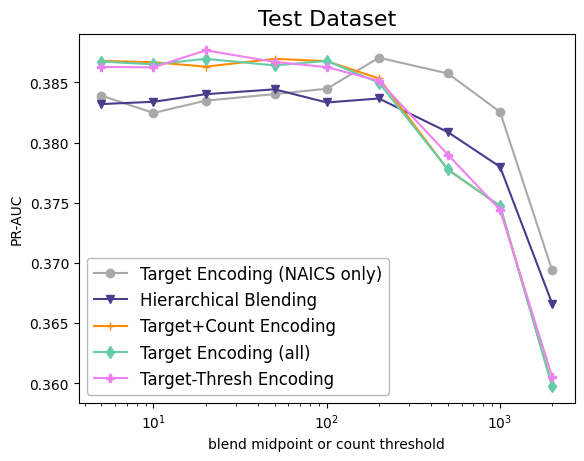

In [23]:
fig = make_plot(metrics_sum_dict, 0, 
                title='Test Dataset')
#plt.gca().legend(frameon=True, fontsize=12).set_bbox_to_anchor((0.9, 0.4))
fig.savefig(Path(setup.temp_path).joinpath('A65_PLOT_compare_base_reg.png'),
            bbox_inches='tight')

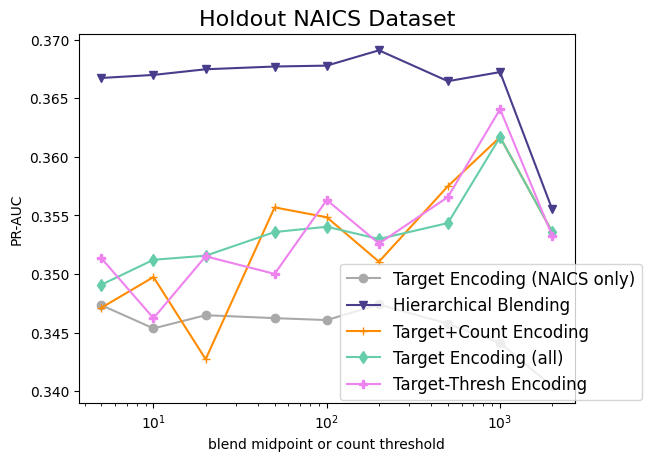

In [24]:
fig = make_plot(metrics_sum_dict, 1, 
                title='Holdout NAICS Dataset')
plt.gca().legend(frameon=True, fontsize=12).set_bbox_to_anchor((0.51, 0.4))
fig.savefig(Path(setup.temp_path).joinpath('A65_PLOT_compare_base_ho.png'),
            bbox_inches='tight')

##### Combined plot

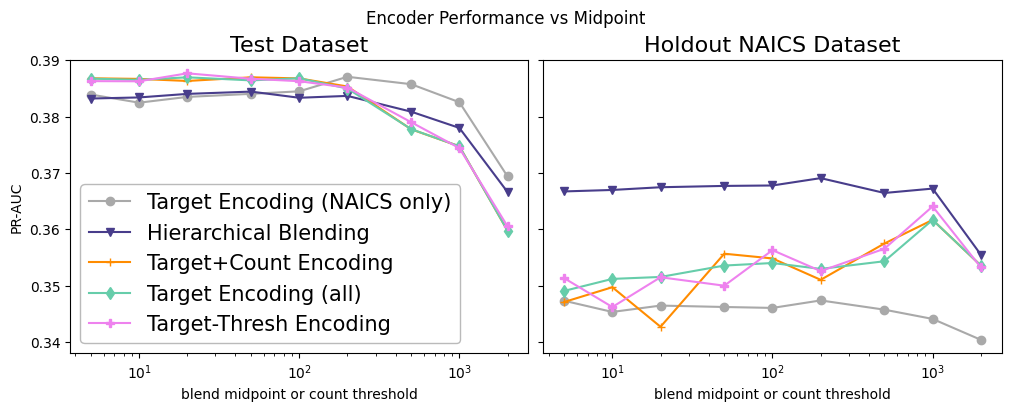

In [25]:
# Combined plot
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True,
                      figsize = (10,4), layout='constrained')
make_plot(metrics_sum_dict, 0, 
                title='Test Dataset',
         ax=ax[0],
         legendsize=15)
make_plot(metrics_sum_dict, 1,
                title='Holdout NAICS Dataset',
         ax=ax[1])
ax[1].legend().set_visible(False)
fig.suptitle('Encoder Performance vs Midpoint')
fig.savefig(Path(setup.temp_path).joinpath('A65_PLOT_compare_base_combined.png'),
            bbox_inches='tight')